<a href="https://colab.research.google.com/github/AlisonJD/RTACourse/blob/main/Best_Practices_for_Views.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

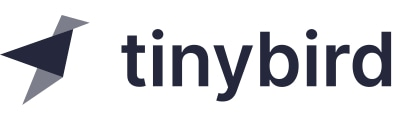
#Principles of Real-Time Analytics Course

**Need to fix 'View Granularity Layers'**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

% cd "/content/gdrive/My Drive/Colab Notebooks/Tinybird"

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/Tinybird


In [2]:
def write_text_to_file(filename, text):
  with open(filename, 'w') as f:
      f.write(text)

In [3]:
!pip install tinybird-cli -q

     |████████████████████████████████| 71 kB 3.6 MB/s 
     |████████████████████████████████| 61 kB 6.1 MB/s 
     |████████████████████████████████| 46 kB 2.9 MB/s 
     |████████████████████████████████| 86 kB 3.8 MB/s 
     |████████████████████████████████| 81 kB 7.3 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
!tb auth

Copy the admin token from https://ui.tinybird.co/tokens and paste it here: 
** Auth successful! 
** Configuration written to .tinyb file, consider adding it to .gitignore


In this notebook we use and create these assets:

|Asset            | Activity      |
| ----------------- |:-------------:|
| taxi.datasource|use|
|taxi__zone_lookup|use|
|denormalize_taxi.pipe| create|
| taxi_mv.datasource|create|
| cost_estimate.pipe|create|
|hits.datasource|use|
|hits_mv.datasource|create|
|hits_per_day.pipe|create|
|events.datasource|use|
|events_per_day_mv.datasource|create|
|events_per_day.pipe|create|
|events_per_month_mv.datasource|create|
|events_per_month.pipe|create|
|hits_per_os_mv.datasource|create|
|hits_per_os.pipe|create|


# Best Practices for Views
Views are a really powerful tool to analyze large amounts of data really quickly. Normal views do not store any data, they just perform a read from another table on each access. Materialized views store data transformed by the corresponding SELECT query. Live views store the result of the corresponding SELECT query and are updated any time the result of the query changes. 

We usually talk about materialized and live views. Here we will focus on materialized views here because they really help solving some real-time problems.

Materialized views are useful because if you frequently run the same query on a table it makes sense to run the query once, save the result and just fetch that result. They have two downsides:
 - They need space.
 - They add management work (especially recalculating them when new data comes in). 
 - They need to be updated and changed if the source schema changes.
 - They generally only work for some use cases.


Let’s see how to manage these issues and leverage views to get 100-1000x improvements.

Views are a way to trade memory and disk to save CPU. That means we will have more things in disk/memory but when we need to use them the CPU will need to fetch less data or do less work than if they didn’t exist.

This means spending more money on disk and less money on CPUs. This is a very good tradeoff since, in the cloud, each CPU can be around 25x more expensive than each GB of disk.

Here we see some use cases and best practices.



## Denormalization on Ingest
This is one of the most common use cases. It means calculating things when the data arrives (on ingestion time) so that you save a version of your original data with extra/enriched/prepared data. You could do the same operations at query time but when you do them on ingest time you execute the operation once and query many times (so the query time is less than it would be without the view).


### Join with a Dimensions Dataset
Here we use the New York City Taxi Trip dataset and the join table `taxi__zone_lookup` to add columns for the pick-up and drop-off boroughs from the dimensions table to the main table using a pipe. The datasources are created [here](https://colab.research.google.com/drive/1dvZAaHs-Xp3QpCUOPpl_Nb97YilLLZp2?usp=sharing). 

In [ ]:
filename = 'pipes/denormalize_taxi.pipe'
text='''
NODE denormalized
SQL >
    SELECT 
    *,
    joinGet('taxi__zone_lookup', 'borough', dolocationid) doborough,
    joinGet('taxi__zone_lookup', 'borough', pulocationid) puborough
    FROM taxi

'''

write_text_to_file(filename, text)

In [ ]:
!cat pipes/denormalize_taxi.pipe


NODE denormalized
SQL >
    SELECT 
    *,
    joinGet('taxi__zone_lookup', 'borough', dolocationid) doborough,
    joinGet('taxi__zone_lookup', 'borough', pulocationid) puborough
    FROM taxi



In [ ]:
!tb push --populate --force pipes/denormalize_taxi.pipe

** Processing pipes/denormalize_taxi.pipe
** Building dependencies
** Running denormalize_taxi 
** => Test endpoint at https://api.tinybird.co/v0/pipes/denormalize_taxi.json
** 'denormalize_taxi' created
** Not pushing fixtures


In [ ]:
!tb sql "SELECT * FROM denormalize_taxi LIMIT 1"

------------------------------------------
vendorid: 2
tpep_pickup_datetime: 2019-03-01 05:01:25
tpep_dropoff_datetime: 2019-03-01 05:05:37
passenger_count: 2
trip_distance: 0.71
ratecodeid: 1
store_and_fwd_flag: N
pulocationid: 138
dolocationid: 223
payment_type: 2
fare_amount: 5
extra: 0.5
mta_tax: 0.5
tip_amount: 0
tolls_amount: 0
improvement_surcharge: 0.3
total_amount: 6.3
congestion_surcharge: 0
doborough: Queens
puborough: Queens
------------------------------------------


### Precalculate Something that would Take a Lot of CPU cycles
Imagine that you have a column that is calculated from others in the table. You could calculate it on ingestion time to avoid running those calculations during the query. 

In this simple example the estimated trip fare is calculated although calculations are usually more complex than just a multiplication.


In [ ]:
!tb sql --stats "SELECT avg(fare_amount/trip_distance) AS avg_per_mile FROM taxi WHERE trip_distance > 0"

** Query took 0.076337073 seconds
** Rows read: 84,152,418
** Bytes read: 673.22 MB
----------------------
|       avg_per_mile |
----------------------
| 7.8073611257267945 |
----------------------


If we create a materialized view of the taxi table with an additional column for the  estimated fare then we can run fast queries without the calculation.

First we create the taxi_mv datasource with the additional column for `estimated_fare`.

In [ ]:
filename="datasources/taxi_mv.datasource"
text='''
SCHEMA >
    `estimated_fare` Float32,
    `vendorid` Int16,
    `tpep_pickup_datetime` DateTime,
    `tpep_dropoff_datetime` DateTime,
    `passenger_count` Nullable(Int16),
    `trip_distance` Float32,
    `ratecodeid` Nullable(Int16),
    `store_and_fwd_flag` String,
    `pulocationid` Int32,
    `dolocationid` Int32,
    `payment_type` Nullable(Int16),
    `fare_amount` Float32,
    `extra` Float32,
    `mta_tax` Float32,
    `tip_amount` Float32,
    `tolls_amount` Float32,
    `improvement_surcharge` Float32,
    `total_amount` Float32,
    `congestion_surcharge` Nullable(Float32)

ENGINE "MergeTree"
ENGINE_PARTITION_KEY "toMonth(tpep_pickup_datetime)"
ENGINE_SORTING_KEY "tpep_pickup_datetime"
'''

write_text_to_file(filename, text)

In [ ]:
!tb push datasources/taxi_mv.datasource

** Processing datasources/taxi_mv.datasource
** Building dependencies
** Running taxi_mv 
** 'taxi_mv' created
** Not pushing fixtures


In [ ]:
filename = 'pipes/cost_estimate.pipe'
text = '''
NODE cost_estimate_node
SQL >

    SELECT
trip_distance * 7.807361125727003 AS estimated_fare,
        *
    FROM taxi

TYPE materialized
DATASOURCE taxi_mv
'''

write_text_to_file(filename, text)

In [ ]:
!tb push pipes/cost_estimate.pipe --skip-table-checks --populate

** Processing pipes/cost_estimate.pipe
** Building dependencies
** Running cost_estimate 
** Materialized node 'cost_estimate_node' used the Data Source 'taxi_mv'
** Populating job url https://api.tinybird.co/v0/jobs/d069fad8-9607-4f7b-a3f0-c7b310b6ec0e
** 'cost_estimate' created
** Not pushing fixtures


In [ ]:
!tb sql --stats "SELECT estimated_fare, fare_amount FROM cost_estimate LIMIT 15"

** Query took 0.001093925 seconds
** Rows read: 15
** Bytes read: 120 bytes
--------------------------------
| estimated_fare | fare_amount |
--------------------------------
|              0 |           0 |
|              0 |           0 |
|     0.23422083 |         2.5 |
|              0 |           0 |
|      19.596476 |        10.5 |
|              0 |           0 |
|      15.927016 |        11.5 |
|              0 |         2.5 |
|              0 |         2.5 |
|              0 |         2.5 |
|    0.078073606 |         2.5 |
|      16.785828 |        11.5 |
|              0 |         2.5 |
|       19.90877 |        10.5 |
|       8.353877 |         5.5 |
--------------------------------


The estimation algorithm is not very good 😅 but the query is super fast and reads little data.

### Precalculate Something that will Help when Joining with other Datasets at Query Time

If you have a join like

```
SELECT * 
FROM A 
JOIN B 
ON A.id = B.id and A.foo = B.foo
-- using id, foo
```

As we saw, you could have an extra column with id + foo so the query would be

```
SELECT * 
FROM A 
JOIN B 
ON A.foo_id = B.foo_id
WHERE attr = 1
````

This speeds up the join because you just read one parameter and just check once. Not only that, it also enables (if your database supports it) hash join which is much faster.

### JSON Data Denormalization

## Use Arrays to Denormalize
A way to save a lot of rows is to use arrays. Mostly for secondary use cases or the ones you would join after a filter.

For example, if we have a table `user_events` with all the mouse clicks or taps during a session, it might make sense to save all of them in the same row using an array instead of saving one row per click. In other words, it’s a way to save a join.

The downside is that databases don’t usually have inverted indices so you might want to generate another column or columns based on array content to be able to index.

In this example, if we define the table as:
```
UserId UInt64
Timestamp DateTime
ClickPoints Array(Int32, Int32)
```
Then we could do a query to search clicks on a particular zone from people older than 70:
```
SELECT x, y from ( 
SELECT * FROM user_events 
JOIN user_info 
USING UserId
WHERE user_info.age > 70
) array join ClickPoints as (x, y)
WHERE x between 10 and 100
```
In this case, if we have, for example, 50 clicks per user as an average, the join will have to do 50x less work. Then the array join generates one entry for each element of the ClickPoints array and we can filter by x, y.

Take into account that this is useful in two main situations:
 - When it allows you to save joins or other expensive operations. If you always need to do the array join this way to store data then it doesn’t make any sense.
 - When you only need the array join for a small % of use cases in which you use the table. Mainly because you optimize the main use case making worse the secondary use cases but improving the timing overall.

## Incremental Views
One of the main problems of views is updating them. That’s why you need to pick a database that allows you to update them incrementally. It does not make any sense to update a view of a 4 billion row table every time you append more data.

So how do you update a view that generates an aggregation? For example,
```
SELECT date, avg(response_time), uniq(user_id) 
FROM events
GROUP BY date
````
You might think the view needs to be fully updated if you append a new event with a new `user_id`. 

You don’t, there are ways to do this really simply. Let’s see an example with the Yandex `hits` dataset. It contains tracking information (like Google Analytics).

Create a destination datasource for the materialized view.

In [ ]:
filename="datasources/hits_mv.datasource"
text='''
SCHEMA >
      `date` DateTime,
      `event_count` Int64,
      `uniq_users` AggregateFunction(uniq, Int64)

ENGINE "AggregatingMergeTree"
ENGINE_PARTITION_KEY "toYYYYMM(date)"
ENGINE_SORTING_KEY "date"
'''

write_text_to_file(filename, text)

In [ ]:
!tb push datasources/hits_mv.datasource 

** Processing datasources/hits_mv.datasource
** Building dependencies
** Running hits_mv 
** 'hits_mv' created
** Not pushing fixtures


In [ ]:
filename="pipes/hits_per_day.pipe"
text='''
NODE per_day

SQL >
    SELECT
        toDate(EventTime) date,
        count() event_count,
        uniqState(UserID) uniq_users
    from hits
    group by date

TYPE materialized
DATASOURCE hits_mv
'''

write_text_to_file(filename, text)

In [ ]:
!tb push pipes/hits_per_day.pipe --populate

** Processing pipes/hits_per_day.pipe
** Building dependencies
** Running hits_per_day 
** Materialized node 'per_day' used the Data Source 'hits_mv'
** Populating job url https://api.tinybird.co/v0/jobs/12f3c0de-dc81-455c-8546-0830a8e5318a
** 'hits_per_day' created
** Not pushing fixtures


Now run the same query against the original table and the materialized view

In [ ]:
!tb sql --stats "SELECT  toDate(EventTime) date, uniq(UserID) u FROM hits GROUP BY date"

** Query took 0.060029403 seconds
** Rows read: 8,873,897
** Bytes read: 106.49 MB
----------------------
| date       |     u |
----------------------
| 2014-03-17 | 36613 |
| 2014-03-18 | 36531 |
| 2014-03-19 | 36940 |
| 2014-03-20 | 36462 |
| 2014-03-21 | 35447 |
| 2014-03-22 | 31555 |
| 2014-03-23 | 31200 |
----------------------


In [ ]:
!tb sql --stats "SELECT date, uniqMerge(uniq_users) u FROM hits_mv GROUP BY date"

** Query took 0.047435721 seconds
** Rows read: 55
** Bytes read: 12.95 KB
-------------------------------
| date                |     u |
-------------------------------
| 2014-03-19 00:00:00 | 36940 |
| 2014-03-21 00:00:00 | 35447 |
| 2014-03-20 00:00:00 | 36462 |
| 2014-03-23 00:00:00 | 31200 |
| 2014-03-22 00:00:00 | 31555 |
| 2014-03-18 00:00:00 | 36531 |
| 2014-03-17 00:00:00 | 36613 |
-------------------------------


The query on the materialized view is faster and reads much less data.

The interesting things to understand here are:
 - When we create the view we use `uniqState` instead of `uniq`. This is what the database uses internally when running a query in the process that runs the map part of the MapReduce. Merging those states (in the “reduce” part) yields the final value.
 - When executing the query against the view we need to use `uniqMerge` to tell the database to merge all the states.
 - Note that we can append more data to the table and we don’t need to recalculate it. 
 - We could add billions of rows per day, the view will only grow according to the number of different users.


##Background View Work
Some databases use background jobs to compact tables. Some databases in this field use Log Structured Merge Trees (LSTM). That means that when you insert data the database writes it to the disk as fast as the hardware allows and then, in the background, merges with other inserts. That improves speed, disk size and so on but has two downsides:
 - Between the insert and the compact job the queries will be slower because it has to query more data.
 - The background job takes resources and it could affect your query times.

During the merge stage some databases allow you to do things. For example, collapse rows, remove duplicates or optimize operations.

##Special View Types
During the merge the database can do things for you, for example, sum columns, aggregate them or replace duplicates.

ClickHouse in this case has several interesting engines. An engine is the way we have to tell ClickHouse what to do in the collapse stage.

 - Summing - Allows us to collapse rows summing the values
 - Aggregating - Allows us to collapse rows doing aggregations. The `uniqMerge`, for example.
 - Replacing - Allows us to collapse rows by removing duplicated rows using an unique id


##View Granularity Layers
A common access pattern is by date. For example

`SELECT sum(clicks) FROM visits WHERE date BETWEEN '2019-01-01' AND '2019-12-13'`


In [205]:
!tb sql --stats "SELECT count() FROM events WHERE event = 'buy' AND (date BETWEEN toDate('2019-01-01') AND toDate('2019-12-13'))"

** Query took 0.030573607 seconds
** Rows read: 19,832,832
** Bytes read: 456.13 MB
-----------
| count() |
-----------
| 3962516 |
-----------


In [224]:
!tb sql --stats "SELECT toDate(date) as date, count() FROM events WHERE event = 'buy' AND date >toDate('2018-12-31') GROUP BY date ORDER BY date"

** Query took 0.1285623 seconds
** Rows read: 68,350,380
** Bytes read: 1.57 GB
------------------------
| date       | count() |
------------------------
| 2019-01-01 |   11412 |
| 2019-01-02 |   11155 |
| 2019-01-03 |   10962 |
| 2019-01-04 |   11092 |
| 2019-01-05 |   11338 |
| 2019-01-06 |   11220 |
| 2019-01-07 |   10902 |
| 2019-01-08 |   10636 |
| 2019-01-09 |   10738 |
| 2019-01-10 |   10553 |
| 2019-01-11 |   10418 |
| 2019-01-12 |   10348 |
| 2019-01-13 |   10361 |
| 2019-01-14 |   10282 |
| 2019-01-15 |   10259 |
| 2019-01-16 |   10288 |
| 2019-01-17 |   10344 |
| 2019-01-18 |   10353 |
| 2019-01-19 |   10398 |
| 2019-01-20 |   10546 |
| 2019-01-21 |   10527 |
| 2019-01-22 |   10289 |
| 2019-01-23 |   10233 |
| 2019-01-24 |   10271 |
| 2019-01-25 |   10451 |
| 2019-01-26 |   10364 |
| 2019-01-27 |   10259 |
| 2019-01-28 |   10202 |
| 2019-01-29 |   10244 |
| 2019-01-30 |   10127 |
| 2019-01-31 |   10159 |
| 2019-02-01 |   10069 |
| 2019-02-02 |    9942 |
| 2019-02-03 |    97

In [207]:
filename="datasources/events_per_day_mv.datasource"
text='''
SCHEMA >
    date Date,
    n Int64

ENGINE AggregatingMergeTree
ENGINE_SORTING_KEY date
'''

write_text_to_file(filename, text)

In [208]:
!tb push datasources/events_per_day_mv.datasource

** Processing datasources/events_per_day_mv.datasource
** Building dependencies
** Running events_per_day_mv 
** 'events_per_day_mv' created
** Not pushing fixtures


In [209]:
filename="pipes/events_per_day.pipe"
text='''
NODE buy_events
SQL >
  SELECT 
    toDate(date) as date, 
    count() 
  FROM events 
  WHERE event = 'buy'
  GROUP BY date

TYPE materialized
DATASOURCE events_per_day_mv
'''

write_text_to_file(filename, text)

In [210]:
!tb push pipes/events_per_day.pipe --skip-table-checks --populate

** Processing pipes/events_per_day.pipe
** Building dependencies
** Running events_per_day 
** Materialized node 'buy_events' used the Data Source 'events_per_day_mv'
** Populating job url https://api.tinybird.co/v0/jobs/c69f63ce-a2b6-4a1c-bcb5-c47a0bf30453
** 'events_per_day' created
** Not pushing fixtures


It makes sense to group your data by day using a view of buying events per day:

In [211]:
!tb sql --stats "SELECT * FROM events_per_day_mv WHERE date BETWEEN toDate('2019-01-01') and toDate('2019-12-13')"

** Query took 0.00010541 seconds
** Rows read: 0
** Bytes read: 0 bytes
** No rows


In [118]:
! tb sql "SELECT * FROM events_per_day_mv WHERE (date BETWEEN toDate('2019-01-01') AND toDate('2019-12-13')) "

-------------------------------
| date                |     n |
-------------------------------
| 2019-01-01 00:00:00 | 10772 |
| 2019-01-02 00:00:00 |  4517 |
| 2019-01-03 00:00:00 |  1864 |
| 2019-01-04 00:00:00 |  1863 |
| 2019-01-05 00:00:00 |  1911 |
| 2019-01-06 00:00:00 |  1844 |
| 2019-01-07 00:00:00 |   211 |
| 2019-01-08 00:00:00 |  1809 |
| 2019-01-09 00:00:00 |  1855 |
| 2019-01-10 00:00:00 |  1719 |
| 2019-01-11 00:00:00 |  1743 |
| 2019-01-12 00:00:00 |  1727 |
| 2019-01-13 00:00:00 |  1698 |
| 2019-01-14 00:00:00 |   700 |
| 2019-01-15 00:00:00 |  5411 |
| 2019-01-16 00:00:00 |  7524 |
| 2019-01-17 00:00:00 |  7973 |
| 2019-01-18 00:00:00 |  4787 |
| 2019-01-19 00:00:00 |  9765 |
| 2019-01-20 00:00:00 |  3635 |
| 2019-01-21 00:00:00 |  1689 |
| 2019-01-22 00:00:00 |   197 |
| 2019-01-23 00:00:00 |  1715 |
| 2019-01-24 00:00:00 |  1742 |
| 2019-01-25 00:00:00 |  1815 |
| 2019-01-26 00:00:00 |  1697 |
| 2019-01-27 00:00:00 |  1764 |
| 2019-01-28 00:00:00 |  1720 |
| 2019-0

DIFFERENT ANSWERS!

In [230]:
filename="datasources/events_per_month_mv.datasource"
text='''
SCHEMA >
    month UInt32,
    n Int64
'''

write_text_to_file(filename, text)

In [231]:
!tb push datasources/events_per_month_mv.datasource

** Processing datasources/events_per_month_mv.datasource
** Building dependencies
** Running events_per_month_mv 
** 'events_per_month_mv' created
** Not pushing fixtures


In [234]:
filename="pipes/events_per_month.pipe"
text='''
NODE events_per_month_node
SQL >

  SELECT
    toYYYYMM(date) as month,
    count() as n
  FROM events
  WHERE event = 'buy'
  GROUP BY month

TYPE materialized
DATASOURCE events_per_month_mv
'''

write_text_to_file(filename, text)

In [236]:
!tb push pipes/events_per_month.pipe --skip-table-checks

** Processing pipes/events_per_month.pipe
** Building dependencies
** Running events_per_month 
** Materialized node 'events_per_month_node' used the Data Source 'events_per_month_mv'
** 'events_per_month' created
** Not pushing fixtures


##Duplicate Data Saves you Money 
This sounds counterintuitive but if you go to your cloud provider and investigate the cost of adding a GB of disk, a GB of memory or a core. Memory and especially cores are really expensive. So using views (or in other words, duplicate data) can save you a lot of money. 


##Same Data -> Different Views
Sometimes the access pattern is different even if the schema you need for the view is the same. In these cases it makes sense to have two views, with the same schema, but sorted in a different way. Remember, data order is key.

We already have a view of the hits dataset by day, here we create one by OS.


In [ ]:
filename="datasources/hits_per_os_mv.datasource"
text='''
SCHEMA >
      `os` Int16,
      `event_count` UInt64,
      `uniq_users` AggregateFunction(uniq, Int64)

ENGINE "AggregatingMergeTree"
ENGINE_SORTING_KEY "os"
'''

write_text_to_file(filename, text)

In [ ]:
!tb push datasources/hits_per_os_mv.datasource

** Processing datasources/hits_per_os_mv.datasource
** Building dependencies
** Running hits_per_os_mv 
** 'hits_per_os_mv' created
** Not pushing fixtures


In [ ]:
filename="pipes/hits_per_os.pipe"
text='''
NODE per_os
SQL >
    SELECT
        assumeNotNull(OS) os,
        count() event_count,
        uniqState(UserID) uniq_users
    from hits
    where os is not null
    group by os

TYPE materialized
DATASOURCE hits_per_os_mv
'''

write_text_to_file(filename, text)

In [ ]:
!tb push pipes/hits_per_os.pipe --populate --skip-table-checks

** Processing pipes/hits_per_os.pipe
** Building dependencies
** Running hits_per_os 
** Materialized node 'per_os' used the Data Source 'hits_per_os_mv'
** Populating job url https://api.tinybird.co/v0/jobs/9c43ac6e-2890-4a1d-881b-65d2bde3ce70
** 'hits_per_os' created
** Not pushing fixtures


In [ ]:
!tb sql --stats "SELECT OS, uniq(UserID) FROM hits GROUP BY OS"

** Query took 0.039554897 seconds
** Rows read: 8,873,897
** Bytes read: 79.87 MB
-----------------------
| OS   | uniq(UserID) |
-----------------------
| 0    |         2377 |
| 1    |         2079 |
| 2    |          297 |
| 3    |        19437 |
| 4    |           44 |
| 5    |            4 |
| 6    |          402 |
| 7    |            5 |
| 8    |         2175 |
| 9    |            1 |
| 12   |           11 |
| 13   |         1203 |
| 14   |           14 |
| 15   |          672 |
| 17   |            2 |
| 18   |          141 |
| 22   |            1 |
| 24   |            2 |
| 25   |            4 |
| 26   |            5 |
| 27   |            1 |
| 28   |            1 |
| 29   |            2 |
| 31   |            2 |
| 41   |         1707 |
| 42   |         9700 |
| 43   |          112 |
| 46   |          468 |
| 48   |            1 |
| 49   |            6 |
| 50   |          120 |
| 53   |           20 |
| 56   |        48586 |
| 59   |            4 |
| 62   |          115 |
| 63  

In [ ]:
!tb sql --stats "SELECT os, uniqMerge(uniq_users) FROM hits_per_os_mv GROUP BY  os"

** Query took 0.026244715 seconds
** Rows read: 495
** Bytes read: 66.39 KB
--------------------------------
| os   | uniqMerge(uniq_users) |
--------------------------------
| 0    |                  2377 |
| 1    |                  2079 |
| 2    |                   297 |
| 3    |                 19437 |
| 4    |                    44 |
| 5    |                     4 |
| 6    |                   402 |
| 7    |                     5 |
| 8    |                  2175 |
| 9    |                     1 |
| 12   |                    11 |
| 13   |                  1203 |
| 14   |                    14 |
| 15   |                   672 |
| 17   |                     2 |
| 18   |                   141 |
| 22   |                     1 |
| 24   |                     2 |
| 25   |                     4 |
| 26   |                     5 |
| 27   |                     1 |
| 28   |                     1 |
| 29   |                     2 |
| 31   |                     2 |
| 41   |                  1707 |


This is not only faster but also as the dataset grows the view query time does not grow with the number of events.